# Загрузка данных

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


from parser.db import client
from datafactory.cuter import split_stratified_into_train_val_test

In [23]:
# Загрузка данных
quakes_df: pd.DataFrame = client.query_df('SELECT * FROM quakes ORDER BY Date')
quakes_class_df = quakes_df.copy()
quakes_class_df['Magnitude'] = np.round(quakes_class_df['Magnitude'], decimals = 0)

# Разбиение датасета на обучающий, валидационный и тестовый
df_train, df_val, df_test = split_stratified_into_train_val_test(quakes_df.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_features = df_train.copy()
test_features = df_test.copy()
val_features = df_val.copy()

train_labels = train_features.pop('Magnitude')
test_labels = test_features.pop('Magnitude')
val_labels = val_features.pop('Magnitude')

In [ ]:
#sns.pairplot(tmp_df[['Magnitude', 'Longitude', 'Latitude', 'Mercury_earth_distance', 'Mercury_sun_distance', 'Mercury_hlat', 'Mercury_hlon', 'Mercury_size']], diag_kind='kde')

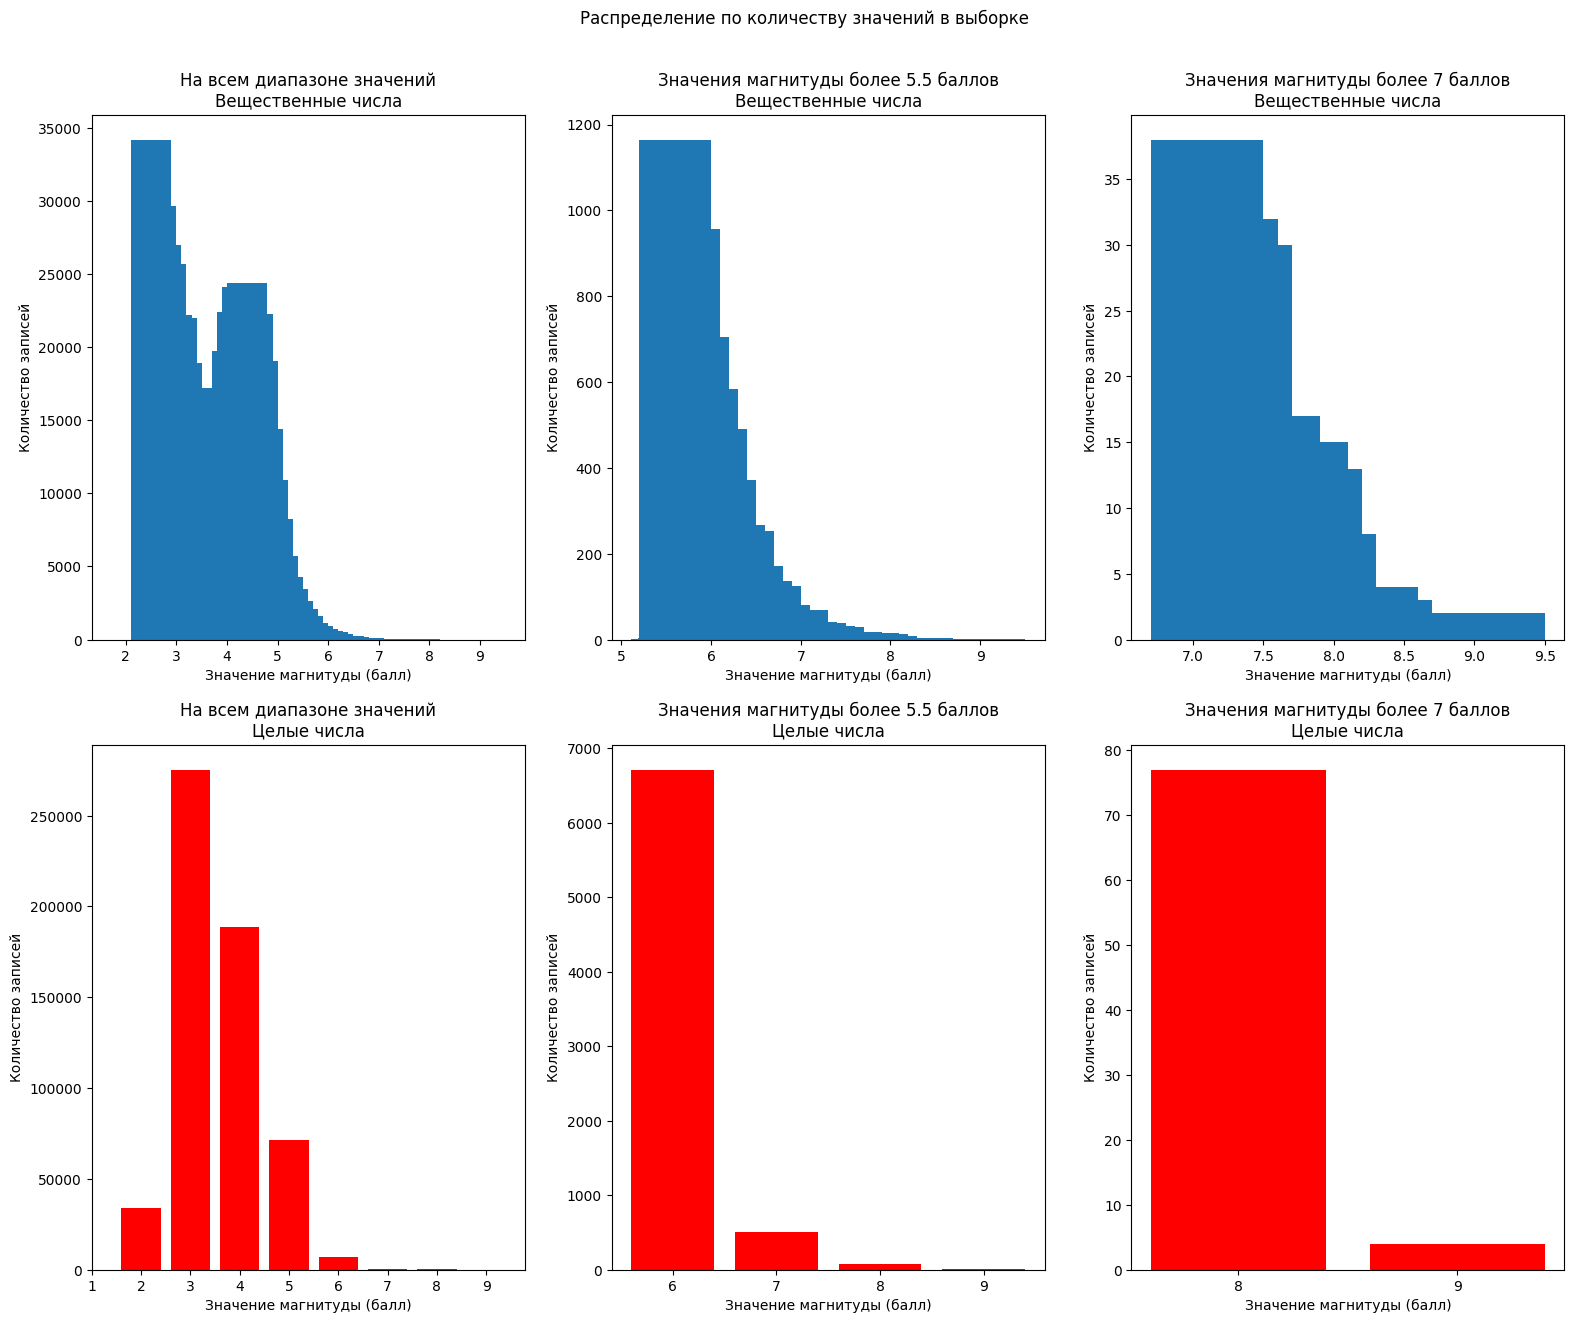

In [20]:
values_count = quakes_df['Magnitude'].value_counts().to_frame().sort_values('Magnitude')
values_count_class = quakes_class_df['Magnitude'].value_counts().to_frame().sort_values('Magnitude')

row, col = 2, 3
plt.figure(figsize=(19,15))
plt.suptitle('Распределение по количеству значений в выборке', y=0.95)

plt.subplot(row, col, 1)
plt.title('На всем диапазоне значений\nВещественные числа')
plt.bar(values_count.index.to_numpy(), values_count['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 2)
plt.title('Значения магнитуды более 5.5 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 5.5].index.to_numpy(), values_count[values_count.index > 5.5]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 3)
plt.title('Значения магнитуды более 7 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 7].index.to_numpy(), values_count[values_count.index > 7]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')


plt.subplot(row, col, 4)
plt.title('На всем диапазоне значений\nЦелые числа')
plt.bar(values_count_class.index.to_numpy(), values_count_class['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks(list(range(1,10)), list(range(1,10)))

plt.subplot(row, col, 5)
plt.title('Значения магнитуды более 5.5 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 5.5].index.to_numpy(), values_count_class[values_count_class.index > 5.5]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([6, 7, 8, 9], [6, 7, 8, 9])

plt.subplot(row, col, 6)
plt.title('Значения магнитуды более 7 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 7].index.to_numpy(), values_count_class[values_count_class.index > 7]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([8,9], [8,9])

plt.show()

In [12]:
values_count_class

,count
Magnitude,
2.0,34187
3.0,275374
4.0,188960
5.0,71218
6.0,6712
7.0,502
8.0,77
9.0,4


In [24]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [70]:
train_features.shape

(346220, 58)

In [99]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ -66.52   18.67  126.85   51.97    0.12    2.6     7.95    0.      0.67
     0.34  166.27  107.48    0.04    2.17   15.22    0.      1.04    0.69
   234.94  247.53    0.03    2.36    5.96    0.      1.74    1.34  890.86
   740.96   -0.02    0.38   33.04    0.      0.36   -0.02 1561.65 1467.47
    -0.03    5.75   15.86    0.      5.86   -0.85    0.37  149.99   -0.09
     5.02 1950.76    0.      5.06   -1.66  149.96    0.      0.      3.54
  1914.68    0.      0.36    0.  ]]

Normalized: [[-0.29 -0.99 -0.68 -0.86  1.55 -0.54  0.42  0.42 -1.36  1.13 -0.06 -1.41
   1.05 -0.53 -0.35 -0.35 -1.1   1.22 -0.15  1.25  1.3  -0.44 -0.3  -0.3
  -0.75  0.97  0.94 -1.59 -1.61 -1.82 -0.93 -0.93 -1.8  -0.05  1.05  0.49
  -1.04  1.26 -1.03 -1.03  1.31 -0.47 -1.1   0.16 -1.39  1.04  1.1   1.1
   1.06 -0.92  0.14  0.    1.26  0.17 -0.15 -0.15 -1.46  0.  ]]


In [71]:
FEATURES = 58

In [25]:
quake_model = keras.Sequential()

quake_model.add(normalizer)

#quake_model.add(layers.Dense(2, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
#quake_model.add(layers.Dropout(0.5))

#quake_model.add(layers.Dense(1, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
#quake_model.add(layers.Dropout(0.5))

quake_model.add(layers.Dense(3, activation='elu'))
#quake_model.add(layers.Dropout(0.5))
quake_model.add(layers.Dense(1, activation='elu'))
#quake_model.add(layers.Dense(2, activation='relu'))
quake_model.add(layers.Dense(1))

quake_model.summary()

quake_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_percentage_error', 'mean_absolute_error'],
)

keras.utils.plot_model(quake_model, show_shapes=True, rankdir="LR")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 58)                117       
 on)                                                             
                                                                 
 dense (Dense)               (None, 3)                 177       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 300 (1.18 KB)
Trainable params: 183 (732.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instruction

In [26]:
history = quake_model.fit(
    train_features,
    train_labels,
    epochs=4,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    #validation_split=0.2,
    validation_data=(val_features.to_numpy(), val_labels.to_numpy())
)

In [199]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,val_mean_absolute_error,epoch
0,0.716428,0.716428,17.239143,0.597197,0.415348,0.415348,14.521675,0.497854,0
1,0.407837,0.407837,14.236362,0.490652,0.404534,0.404534,14.220958,0.490513,1
2,0.394052,0.394052,13.950539,0.482801,0.390005,0.390005,14.177390,0.485893,2
3,0.379870,0.379870,13.640252,0.473678,0.375498,0.375498,13.591681,0.471246,3


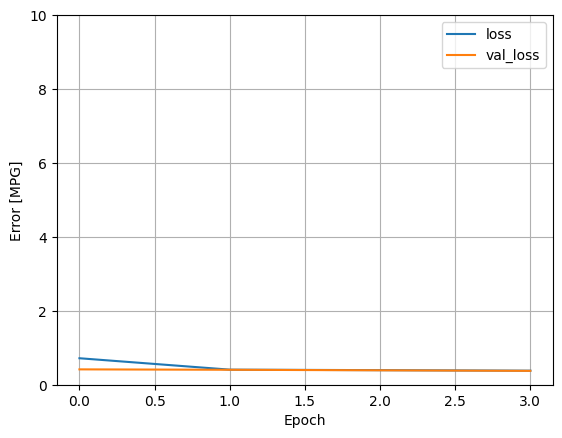

In [200]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [201]:
from sklearn.metrics import r2_score

y_pred = quake_model.predict(test_features)
r2_score(test_labels.to_numpy(), y_pred)

4509/4509 [==============================] - 2s 428us/step


0.465988186741646

In [204]:
y_pred.min()

2.615782

# Вариант классификации

In [199]:
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical

In [169]:
# Разбиение датасета на обучающий, валидационный и тестовый
df_class_train, df_class_val, df_class_test = split_stratified_into_train_val_test(quakes_class_df.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_class_features = df_class_train.copy()
test_class_features = df_class_val.copy()
val_class_features = df_class_test.copy()

train_labels = train_class_features.pop('Magnitude')
test_labels = test_class_features.pop('Magnitude')
val_labels = val_class_features.pop('Magnitude')

nb_classes = 10
y_train = to_categorical(train_labels.to_numpy().astype(int), nb_classes)
y_test = to_categorical(test_labels.to_numpy().astype(int), nb_classes)
y_val = to_categorical(val_labels.to_numpy().astype(int), nb_classes)

normalizer_class = tf.keras.layers.Normalization(axis=-1)
normalizer_class.adapt(np.array(train_class_features))

In [170]:
train_class_features.shape

(346220, 58)

In [140]:
test_labels.value_counts()

Magnitude
3.0    41091
4.0    28545
5.0    10613
2.0     5232
6.0      994
7.0       72
8.0        6
9.0        2
Name: count, dtype: int64

In [194]:
quake_class_model = keras.Sequential()

quake_class_model.add(normalizer)
quake_class_model.add(layers.Dense(3, activation='elu'))
#quake_class_model.add(layers.Dropout(0.25))

quake_class_model.add(layers.Dense(1, activation='elu'))
#quake_class_model.add(layers.MaxPooling1D(pool_size=3))
#quake_class_model.add(layers.Dropout(0.25))

quake_class_model.add(layers.Dense(1, activation='elu'))
#quake_class_model.add(layers.Dropout(0.50))

quake_class_model.add(layers.Dense(nb_classes, activation='sigmoid'))

quake_class_model.summary()

quake_class_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', [Recall(), Precision(), F1Score()]]
)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 58)                117       
 on)                                                             
                                                                 
 dense_79 (Dense)            (None, 3)                 177       
                                                                 
 dense_80 (Dense)            (None, 1)                 4         
                                                                 
 dense_81 (Dense)            (None, 1)                 2         
                                                                 
 dense_82 (Dense)            (None, 10)                20        
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 203 (812.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_______________

In [195]:
history = quake_class_model.fit(
    train_class_features,
    y_train,
    epochs=15,
    verbose=1,
    validation_data=(val_class_features.to_numpy(), y_val)
)

Epoch 1/15
10820/10820 [==============================] - 10s 915us/step - loss: 1.0549 - accuracy: 0.6005 - recall_19: 0.9772 - precision_19: 0.2686 - val_loss: 0.9434 - val_accuracy: 0.6393 - val_recall_19: 0.9825 - val_precision_19: 0.2779
Epoch 2/15
10820/10820 [==============================] - 10s 893us/step - loss: 0.9356 - accuracy: 0.6401 - recall_19: 0.9830 - precision_19: 0.2796 - val_loss: 0.9323 - val_accuracy: 0.6423 - val_recall_19: 0.9826 - val_precision_19: 0.2805
Epoch 3/15
10820/10820 [==============================] - 10s 931us/step - loss: 0.9266 - accuracy: 0.6442 - recall_19: 0.9829 - precision_19: 0.2812 - val_loss: 0.9225 - val_accuracy: 0.6481 - val_recall_19: 0.9832 - val_precision_19: 0.2812
Epoch 4/15
10820/10820 [==============================] - 9s 873us/step - loss: 0.9107 - accuracy: 0.6550 - recall_19: 0.9828 - precision_19: 0.2831 - val_loss: 0.9027 - val_accuracy: 0.6635 - val_recall_19: 0.9820 - val_precision_19: 0.2846
Epoch 5/15
10820/10820 [=====

In [196]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,recall_19,precision_19,val_loss,val_accuracy,val_recall_19,val_precision_19,epoch
0,1.054923,0.600537,0.977237,0.268581,0.943377,0.639274,0.982525,0.277927,0
1,0.935552,0.640119,0.983045,0.279565,0.932296,0.642262,0.982608,0.280498,1
2,0.926590,0.644220,0.982939,0.281173,0.922513,0.648077,0.983169,0.281170,2
3,0.910683,0.655000,0.982788,0.283092,0.902669,0.663453,0.981956,0.284582,3
4,0.897056,0.664777,0.982534,0.285617,0.895671,0.668284,0.980882,0.287040,4
5,0.892105,0.667472,0.981749,0.287198,0.892895,0.667993,0.981817,0.286463,5
6,0.889824,0.669054,0.981258,0.288075,0.889639,0.671903,0.980175,0.288195,6
7,0.888247,0.670045,0.980729,0.288793,0.889849,0.671646,0.980015,0.289176,7
8,0.886848,0.671550,0.980192,0.289302,0.886871,0.674218,0.979558,0.289148,8
9,0.885837,0.672572,0.979715,0.289768,0.889379,0.673414,0.978899,0.290262,9


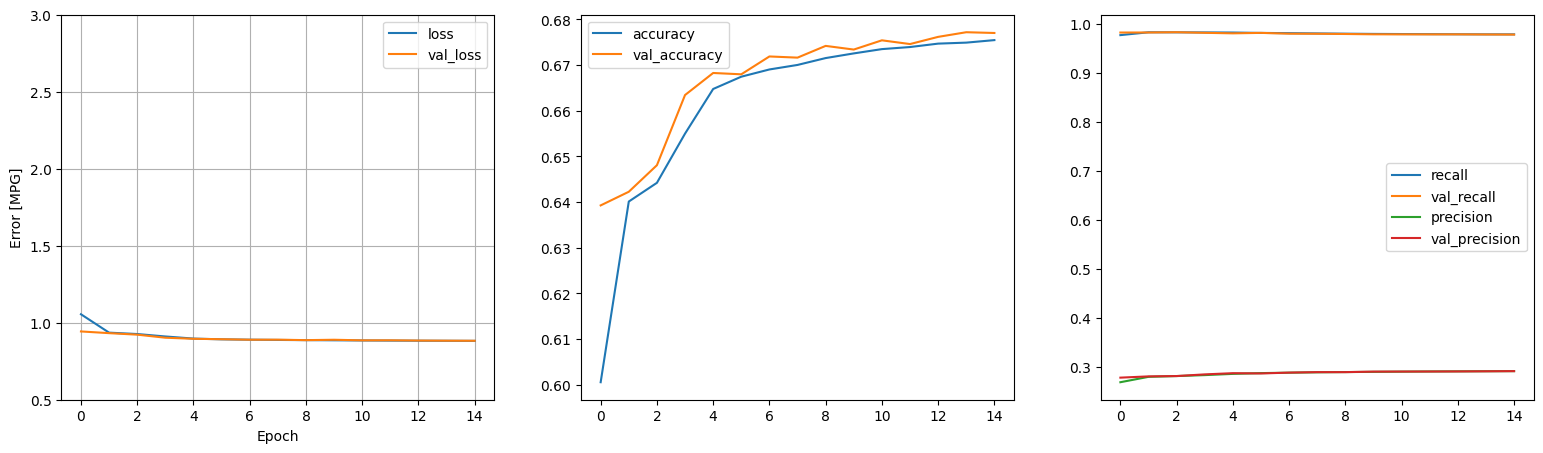

In [197]:
def plot_loss(history):
    plt.figure(figsize=(19,5))
    row, col = 1, 3
    plt.subplot(row, col, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0.5, 3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

    plt.subplot(row, col, 2)
    #plt.ylim([0.475, 0.480])
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()

    plt.subplot(row, col, 3)
    num = 19
    plt.plot(history.history[f'recall_{num}'], label='recall')
    plt.plot(history.history[f'val_recall_{num}'], label='val_recall')
    plt.plot(history.history[f'precision_{num}'], label='precision')
    plt.plot(history.history[f'val_precision_{num}'], label='val_precision')
    plt.legend()

plot_loss(history)

In [198]:
prediction = quake_class_model.predict(test_class_features)

answer = []
for row in prediction:
    answer.append(np.argmax(row))

np.unique(np.array(answer))

2705/2705 [==============================] - 1s 439us/step


array([3, 4])